In [142]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import scipy.signal as signal

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

## get data

In [143]:
directory = 'Z:/Reed/Projects/lab misc/echo_cfu_count/'

file = '20200123 1536 echu cfu test.xlsx'

In [144]:
d = pd.read_excel(directory + file, sheet_name=None)

In [145]:
d.keys()

odict_keys(['Plate 1', 'Plate 2', 'Plate 3', 'Plate 4', 't0 seal', 't0', 'te', 'tef', 't0_tidy', 'te_tidy', 'tef_tidy', 'tall_tidy', 'IDs'])

In [146]:
df = d['tall_tidy']

In [147]:
df.head()

,row,col,OD700,RFP,CFP,YFP,time,cell,dil
0,A,1,0.455,82,1299,71,0,2c1r,10
1,A,2,0.061,28,70,6,0,2c1r,10
2,A,3,0.447,64,1053,41,0,2c1r,10
3,A,4,0.523,122,2299,94,0,2c1r,10
4,A,5,0.543,7984,2500,111,0,2c1r,10


## take out a condition to test

In [148]:
#if you just want to take one plate, give the appropriate thing here
plate = 0

#if you want to do subconditions
subcond = False

cell = '2c1y'
time = 0
dil = 10000
meas = 'OD700'

In [149]:
if subcond == True:

    i1 = df['cell'] == cell
    i2 = df['time'] == time
    i3 = df['dil'] == dil

    i = i1 & i2 & i3
    
else:
    #depending on the experiment, you will have to edit this line to get one plate
    i = df['time'] == plate

sub = df.loc[i, meas]

In [150]:
sub

0       0.455
1       0.061
2       0.447
3       0.523
4       0.543
5       0.481
6       0.587
7       0.506
8       0.523
9       0.535
10      0.554
11      0.607
12      0.529
13      0.502
14      0.576
15      0.563
16      0.570
17      0.633
18      0.570
19      0.500
20      0.513
21      0.489
22      0.435
23      0.484
24      0.553
25      0.558
26      0.530
27      0.492
28      0.601
29      0.516
        ...  
1506    0.474
1507    0.427
1508    0.475
1509    0.440
1510    0.494
1511    0.444
1512    0.443
1513    0.417
1514    0.478
1515    0.408
1516    0.462
1517    0.467
1518    0.497
1519    0.462
1520    0.480
1521    0.435
1522    0.480
1523    0.453
1524    0.437
1525    0.433
1526    0.426
1527    0.450
1528    0.454
1529    0.407
1530    0.460
1531    0.390
1532    0.451
1533    0.398
1534    0.478
1535    0.384
Name: OD700, Length: 1536, dtype: float64

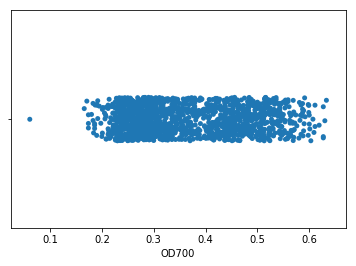

In [151]:
ax = sns.stripplot(x=sub)

## start making GMM models

In [152]:
def get_peak_locations_from_KDE_fit(data, plot=True):
    ''' Performs a KDE fit and then uses scipy.signal.find_peaks_cwt to get peaks.
        The KDE bandwith parameter is critical, and 0.025 seems appropriate for OD700 data that isn't very widely
        distributed (is only between 0 and 1). 
        If it feels like you are missing many peak calls, decrease the bandwith. If it feels
        like you are having too many peak calls, increase the bandwith. 
        
        Don't change the bandwith without good reason, but one bandwidth will not be appropriate for all data
        
        more discussion of bandwidth and kde found here:
            #explanation of what it is and what parameters exist
        https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28
        https://mathisonian.github.io/kde/
            #implementations
        https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
        
        
        Additionally, the widths given for the wavelets (i think) used in the wavelet convolution peak finder
        are critical as well, they should cover the approximate possible widths of your peaks. This is as critical
        as the bandwidth parameter in the kde and will affect the accuracy of peak finding. If your kde bandwidth
        produces a smooth enough kde function, you can probably just use a simpler function like scipy.signal.find_peaks
        that just finds all local maxima by comparing values. Haven't tested the simpler algorithm yet.
        
        '''
                        #critical param, fiddle with it to avoid oversmoothing (too large)
                        #or undersmoothing (too small) and just getting the distribution back
                        #think of this like adjusting histogram bin size
    kde = KernelDensity(bandwidth=0.025, kernel='gaussian')

    kde.fit(sub[:, None]);

    #no points in our OD700 data exceed value 1, so it is unnecessary to score values far outside of that
    #doing so will probably ruin your peak estimation
    x_est = np.linspace(0,1.0,1000)

    log_dens = kde.score_samples(x_est[:,None])

    #Use the SciPy function to get the KDE peaks
                                                #critical param. if too small, will pick up "peaks" that are tiny or not
                                                #really there. If too large, will be very innacurate.
    peaks = signal.find_peaks_cwt(log_dens, np.arange(0.1, 0.5), min_snr=1)

    means_init = []
    
    for peak in peaks:
        means_init.append(x_est[peak])
    
        #plot the KDE and peaks so you can check
    if plot==True:
        fig, ax = plt.subplots()

        ax.plot(x_est, np.exp(log_dens))
        ax.hist(data, density=True);
        for m in means_init:
            ax.axvline(m)
    
    
    return means_init, fig

In [153]:
def fit_GMM_KDE(data, peaks): 
    """Generate a Gaussian mixture model from the output
    of a Gaussian Kernel Density Estimation. 
    
    Outputs the mean of the on peak, fraction on, mean of the off peak, 
    and fraction off. This version of the code assumes all cells not in the on peak are off!
    This is obviously only a good assumption for uni/bimodal data. If you have multimodal data,
    do not use this code."""
    
    #since you're passing a series instead of an array, convert to an array in format that Gaussian Mixture likes
    data = data.values.reshape(len(sub), 1)

    #peaks are passed as a list, so make them an array in proper format
    peaks = np.array(peaks).reshape(len(peaks), 1)
    
    #create the GMM with components equal to number of peaks found in your KDE fit, with initial means equal
    #to the peaks you founs
    opt_gmm = GaussianMixture(n_components = len(peaks) , means_init = peaks).fit(data)  

    #built in method to predict the gaussian to which each data point belongs
    labels = opt_gmm.predict(data)
    labels = np.ravel(labels.reshape(len(labels), 1))

    means = opt_gmm.means_
    
    #this df contains each measurement value and the gaussian it is associated with.
    #you can use this to pull out the measurements that fall into the desired gaussian for gating.
    df = pd.DataFrame({'value': np.ravel(data), 'which_gaussian': labels})
        
        
    return df, means

In [154]:
def assign_gmmpeak_kdefit (data, show_plots=True):
    
    peaks, fig = get_peak_locations_from_KDE_fit(data, show_plots)
    
    assignment, new_means = fit_GMM_KDE(sub, peaks)
    
    if show_plots == True:
        ax = fig.get_axes()[0]
        
        #just a list that should be too long so you can subsample it later. The number of peaks can't exceed this len
        colors = ['r', 'g', 'b', 'k']

        for i in range(len(new_means)):
            d = assignment.loc[assignment['which_gaussian'] == i, 'value']
            ax.eventplot(positions=d, color=colors[i], linelengths=0.5, lineoffsets=0, linewidths=0.25)
            ax.axvline(new_means[i], linestyle = '--')
            
    return assignment, new_means, peaks, fig

C:\Users\geeze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


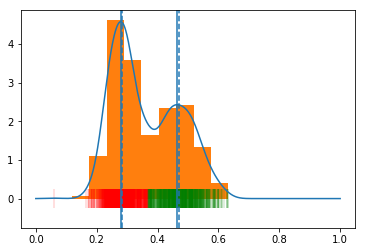

In [155]:
assignment, new_means, peaks, fig = assign_gmmpeak_kdefit(sub)

In [156]:
peaks

[0.27927927927927926, 0.46446446446446443]

In [157]:
assignment['which_gaussian'].sum()

649

In [158]:
len(assignment['which_gaussian'])

1536